## Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
import pathlib
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Add
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras import optimizers
from keras import callbacks
from keras.callbacks import ModelCheckpoint
import numpy as np
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix
import splitfolders

def plot_confusion_matrix(y_true, y_pred, classes,
                          cmap=plt.cm.YlGn):
    title="Confusion Matrix"

    cm = confusion_matrix(y_true, y_pred)
    classes = classes

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    plt.setp(ax.get_xticklabels(), rotation=28, ha="right",rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Dataset Load

In [3]:
#dataset_dir=pathlib.Path('Dataset/')
#to split
#splitfolders.ratio(dataset_dir, output="output",seed=1337, ratio=(.7,.15,.15), group_prefix=None)

dataset_dir=pathlib.Path('output/')

batch_size=32
img_height=160
img_width=200

train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.1,\
    rotation_range=10,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)

train_dir=pathlib.Path('output/train/')
val_dir=pathlib.Path('output/val/')

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)


Found 6259 images belonging to 8 classes.
Found 1338 images belonging to 8 classes.
Image input (160, 200, 3)
Classes: ['Carpet_Cleaners', 'Figs', 'Forks', 'Oatmeal_box', 'Puffed_Snacks', 'Sports_Drinking_Water', 'decorative_tray', 'pasta_bowl']


## Visualize 9 examples

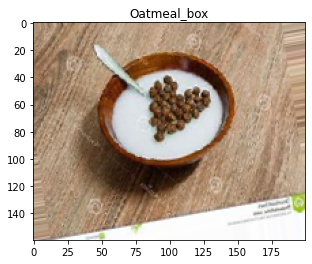

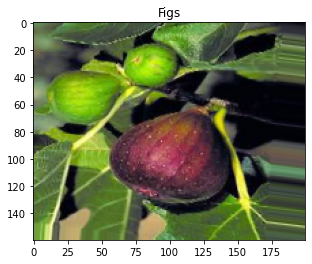

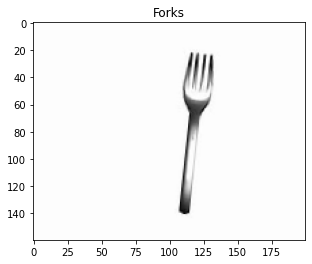

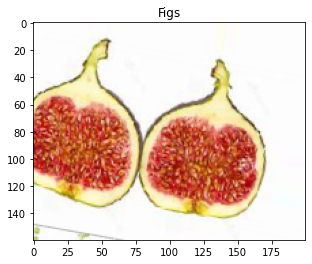

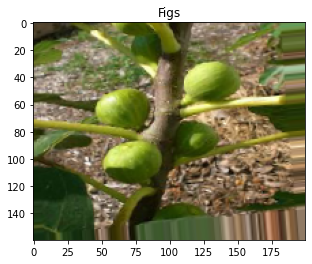

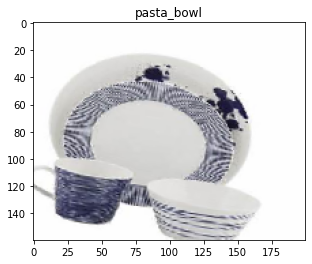

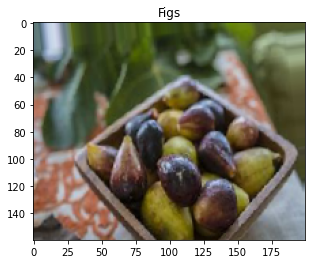

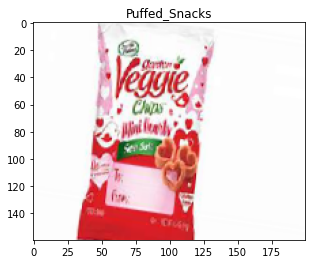

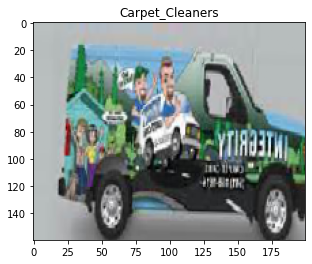

In [51]:
n = 9
x,y = train_generator.next()

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    plt.title(classnames[label])
    plt.imshow(image)
    plt.show()

## Model definition 

In [4]:
def create_model(input_shape):
  model= Sequential()
  model.add(Conv2D(filters=32,kernel_size=(5,5),input_shape=input_shape, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding="valid"))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64,kernel_size=(5,5), padding='same', activation='relu'))
  model.add(Conv2D(filters=64,kernel_size=(3,3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3),strides=(3,3), padding="valid"))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters=96,kernel_size=(5,5), padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding="valid"))
  model.add(BatchNormalization())

  model.add(Flatten())
  flatten_shape=(input_shape[0]*input_shape[1]*input_shape[2],)

  model.add(Dense(256, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(0.0001)))
  model.add(Activation('relu'))

  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

  return model

model=create_model(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 200, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 100, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 100, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 100, 64)       51264     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 100, 64)       36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 33, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 26, 33, 64)        0

## Train the model

In [5]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1
epochs = 50

#stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
try:
    history = model.fit(train_generator, epochs=epochs, verbose=1,\
                    #callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/50
195/195 [==============================] - 550s 3s/step - loss: 2.0084 - accuracy: 0.3366 - val_loss: 2.8206 - val_accuracy: 0.1891
Epoch 2/50
195/195 [==============================] - 496s 3s/step - loss: 1.6432 - accuracy: 0.4514 - val_loss: 1.8274 - val_accuracy: 0.4148
Epoch 3/50
195/195 [==============================] - 525s 3s/step - loss: 1.4739 - accuracy: 0.5097 - val_loss: 1.6675 - val_accuracy: 0.4148
Epoch 4/50
195/195 [==============================] - 525s 3s/step - loss: 1.4106 - accuracy: 0.5412 - val_loss: 1.2129 - val_accuracy: 0.6069
Epoch 5/50
195/195 [==============================] - 574s 3s/step - loss: 1.3241 - accuracy: 0.5744 - val_loss: 1.2392 - val_accuracy: 0.6054
Epoch 6/50
195/195 [==============================] - 553s 3s/step - loss: 1.2818 - accuracy: 0.5924 - val_loss: 1.5489 - val_accuracy: 0.4948
Epoch 7/50
195/195 [==============================] - 554s 3s/step - loss: 1.2685 - accuracy: 0.6013 - val_loss: 1.7223 - val_accuracy: 0.4925

## Save the model

In [6]:
import os
import pickle 

models_dir='./Models/'

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

def savehistory(history,problem):
    filename = os.path.join(models_dir, '%s.hist' %problem)
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    print("\nHystory saved on file %s\n" %filename)

# Save the model
savemodel(model,'Hw2_1_epoc50')
savehistory(history,'Hw2_1_epoc50')





Model saved successfully on file ./Models/Hw2_1_epoc50.h5


Hystory saved on file ./Models/Hw2_1_epoc50.hist



## Plot the results [train,test]

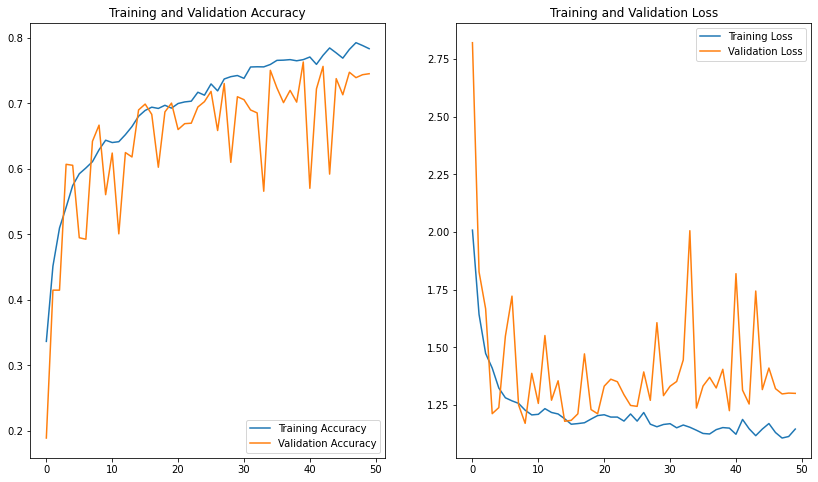

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
#epochs_range=range()

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Load a trained model

In [9]:
def load(name):
    loaded=load_model(name)
    loaded.summary()
    return loaded

model_path="./Models/Hw2_1_epoc50.h5"
model = load(model_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 200, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 100, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 100, 32)       128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 100, 64)       51264     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 100, 64)       36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 33, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 26, 33, 64)        0

## Test the model

In [10]:
test_dir=pathlib.Path('output/test')

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = model.evaluate(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

Found 1352 images belonging to 8 classes.
43/43 [==============================] - 24s 547ms/step - loss: 1.3556 - accuracy: 0.7249
Test loss: 1.355571
Test accuracy: 0.724852


## Classification Report and Confusion Matrix

Found 1352 images belonging to 8 classes.
43/43 [==============================] - 23s 538ms/step
                       precision    recall  f1-score   support

      Carpet_Cleaners      0.813     0.547     0.654       159
                 Figs      0.798     0.868     0.831       159
                Forks      0.707     0.788     0.746       184
          Oatmeal_box      0.743     0.497     0.595       157
        Puffed_Snacks      0.691     0.751     0.720       173
Sports_Drinking_Water      0.702     0.808     0.751       172
      decorative_tray      0.619     0.747     0.677       174
           pasta_bowl      0.801     0.764     0.782       174

             accuracy                          0.725      1352
            macro avg      0.734     0.721     0.720      1352
         weighted avg      0.733     0.725     0.721      1352

True                 Predicted         	errors 	err % 
------------------------------------------------------------------
Oatmeal_box      ->  

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

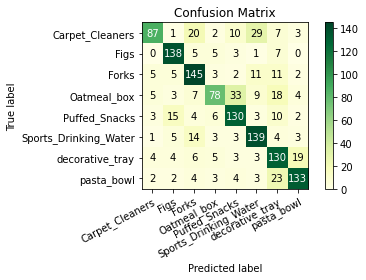

In [11]:
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

preds = model.predict(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

plot_confusion_matrix(Ytest,Ypred, classes=classnames)